<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/R_tabilao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')
tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)

tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)

tilyvoatana.index = pd.to_datetime(tilyvoatana.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)

tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

In [0]:
# Voa vaovao (observed incidence)
Ivao = tilyvoamdg['Voatomb']

dIvao = pd.DataFrame(data =Ivao)

dIvao['Datint'] = range(len(Ivao))


# Hoan'ny taha sorisoritry ny fifindrana (infectioness profile distribution)

daty_data_manom = datetime.date(2020,4,1)
daty_data_mifar = datetime.date(2020,6,3)

datyt = daty_data_mifar - datetime.timedelta(days = 1)

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
si_sh = 1/(0.62**2) # Report 13
si_sc = 6.5/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

#discr_si1 = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)

# 1 The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  for i in range(k):
    Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2 Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0) 
# but include the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  for i in range(k):
    Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := um(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3 The sum of total infectiousness before t over a generic window (t-k+1,t)

def tlsi(t,k):
  tlsi = 0
  for i in range(k):
    tlsi = tlsi + lsi(t - datetime.timedelta(days = k))
  return tlsi

# 4 The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = Isi(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k))/(1 + si(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k))/(1 + lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5 Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [91]:
# APE9_part1 

# for i in range(8):
# t = t_mif - i - 1
# k = 9

APEt91 = []
Prt91 = []

APE91 = 0

for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2) - 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

# for i in range(9):
# t = t_mif - 1 - 9 + 1 - i
# k = t_mif - t - 2*i
APEt92 = []
Prt92 = []

APE92 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2)-1):
  t = daty_data_mifar - datetime.timedelta(days = 1) - datetime.timedelta(days = ((daty_data_mifar - daty_data_manom).days + 1)/2) + datetime.timedelta(days = 1) - datetime.timedelta(days = i)
  k = (daty_data_mifar - t - datetime.timedelta(days = 2*i)).days
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k) ,t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0
# so that pnb(t_man + 1, 2) = 0 and 

For k = 9, APE91 = 2998.3585247344436
APEt91 = [(223.59127784593224, datetime.date(2020, 6, 2)), (49.356191956722114, datetime.date(2020, 6, 1)), (115.63666218876472, datetime.date(2020, 5, 31)), (98.66702246948938, datetime.date(2020, 5, 30)), (217.15841005391175, datetime.date(2020, 5, 29)), (143.41857287551392, datetime.date(2020, 5, 28)), (160.41706549800077, datetime.date(2020, 5, 27)), (88.2430276722167, datetime.date(2020, 5, 26)), (181.3855281262155, datetime.date(2020, 5, 25)), (50.36010701770405, datetime.date(2020, 5, 24)), (169.63356798020976, datetime.date(2020, 5, 23)), (179.50542552643867, datetime.date(2020, 5, 22)), (199.52284212950082, datetime.date(2020, 5, 21)), (152.4888454808861, datetime.date(2020, 5, 20)), (217.1482541013233, datetime.date(2020, 5, 19)), (11.415894023519723, datetime.date(2020, 5, 18)), (72.4526038662288, datetime.date(2020, 5, 17)), (86.80505516216361, datetime.date(2020, 5, 16)), (217.84501268098165, datetime.date(2020, 5, 15)), (26.9790393735

In [92]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
  APEk1.append(APEj1)

print('APEk1 =', APEk1)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

APEk1 = [3748.5734468526803, 3735.5449681368223, 3691.525699980399, 3654.7945759538584, 3597.5168294725604, 3533.6577350509287, 3460.3039957153615]
APEk2 = [12.778246509432757, 30.099989580389412, 38.704397267039106, 46.84311470428777, 56.84997460353424, 73.79925039616424, 91.97662529044212]


In [93]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

print('APE9 =', APE9)
print('APEk =', APEk)

APE9 = 4378.279990865154
APEk = [3761.351693362113, 3765.6449577172116, 3730.230097247438, 3701.6376906581463, 3654.3668040760945, 3607.456985447093, 3552.2806210058034]


In [94]:
# Prior Gamma distribution of Rt

Rtpr_sh = 0.1 # shape
Rtpr_sc =  0.1 # scale

# Posterior distribution for Rt

# Shape parameter :
def Rtps_sh(t):
   return Rtpr_sh + Ireh(t,8)

# Scale
def Rtps_sc(t):
  return 1/(1/Rtpr_sc + tlsi(t,8))

# mean
def Rtps_salan(t):
  return Rtps_sh(t)*Rtps_sc(t)

print("Salan'isa R hoan'ny", datyt, ':', Rtps_salan(datyt))

Salan'isa R hoan'ny 2020-06-02 : 1.3082125033617817


In [0]:
# The 95th and 5th percentiles of Rt

def perc95(t):
  return gengamma.ppf(0.95, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))

def perc05(t):
  return gengamma.ppf(0.05, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))



In [101]:
# Plotting

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, date_py.month)

daty_lst = []

salan_Rt = []
perc95_lst = []
perc05_lst = []

salan_Rt_dat = []
salan_Rt_perc_dat = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) - 1)):
  t = daty_data_manom + datetime.timedelta(days = i+1)
  daty = formatf_date(t)
  daty_lst.append(daty)
  salan_Rt.append(Rtps_salan(t))
  perc95_lst.append(perc95(t))
  perc05_lst.append(perc05(t))
  salan_Rt_dat.append((Rtps_salan(t),t))
  salan_Rt_perc_dat.append((perc95(t),Rtps_salan(t),perc05(t),t))

salan_Rt_dat

[(4.11, datetime.date(2020, 4, 2)),
 (4.41, datetime.date(2020, 4, 3)),
 (2.91, datetime.date(2020, 4, 4)),
 (2.6100000000000003, datetime.date(2020, 4, 5)),
 (3.2100000000000004, datetime.date(2020, 4, 6)),
 (3.7100000000000004, datetime.date(2020, 4, 7)),
 (3.8100000000000005, datetime.date(2020, 4, 8)),
 (3.6100000000000003, datetime.date(2020, 4, 9)),
 (3.517187607461698, datetime.date(2020, 4, 10)),
 (2.4505657913403365, datetime.date(2020, 4, 11)),
 (1.8740037079655145, datetime.date(2020, 4, 12)),
 (1.40736200872761, datetime.date(2020, 4, 13)),
 (0.9694790366700133, datetime.date(2020, 4, 14)),
 (0.6526879545710255, datetime.date(2020, 4, 15)),
 (0.6665806080619446, datetime.date(2020, 4, 16)),
 (0.6345177513997077, datetime.date(2020, 4, 17)),
 (0.4223769211919991, datetime.date(2020, 4, 18)),
 (0.37951187039147793, datetime.date(2020, 4, 19)),
 (0.35276905602416364, datetime.date(2020, 4, 20)),
 (0.31429410701580324, datetime.date(2020, 4, 21)),
 (0.2794038495401873, datetime

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


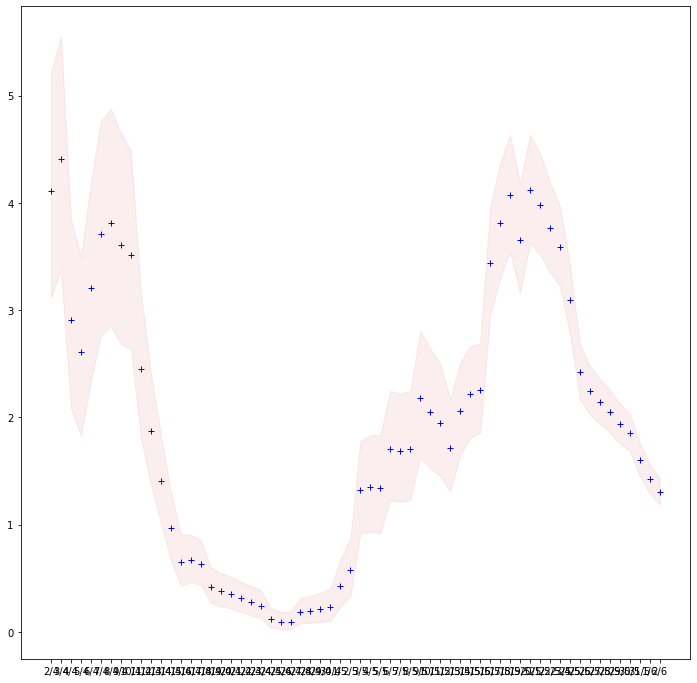

In [97]:
# Plotting

fig = plt.figure(figsize=(12, 12))

plt.plot(daty_lst, salan_Rt, 'b',  marker ="+",ls = 'None')
plt.fill_between(daty_lst, perc05_lst, perc95_lst, alpha=0.08, color="tab:red")


plt.savefig(path_to_save+'R_2_4_2_6.eps')
plt.show()

In [0]:
# From 01/05 to 01/06 data:

R_2_31 = [(1.31, datetime.date(2020, 5, 2)),
 (2.6100000000000003, datetime.date(2020, 5, 3)),
 (2.5100000000000002, datetime.date(2020, 5, 4)),
 (2.6100000000000003, datetime.date(2020, 5, 5)),
 (3.0100000000000002, datetime.date(2020, 5, 6)),
 (3.0100000000000002, datetime.date(2020, 5, 7)),
 (3.0100000000000002, datetime.date(2020, 5, 8)),
 (4.11, datetime.date(2020, 5, 9)),
 (3.91, datetime.date(2020, 5, 10)),
 (4.3767780913779, datetime.date(2020, 5, 11)),
 (2.9949761573723, datetime.date(2020, 5, 12)),
 (2.8361687501387802, datetime.date(2020, 5, 13)),
 (2.7958206100022545, datetime.date(2020, 5, 14)),
 (2.4796399001797464, datetime.date(2020, 5, 15)),
 (3.443033307137812, datetime.date(2020, 5, 16)),
 (3.8554240895233494, datetime.date(2020, 5, 17)),
 (4.115043463524598, datetime.date(2020, 5, 18)),
 (3.932100438170955, datetime.date(2020, 5, 19)),
 (4.506062261092727, datetime.date(2020, 5, 20)),
 (4.523619207285901, datetime.date(2020, 5, 21)),
 (4.458931264645666, datetime.date(2020, 5, 22)),
 (4.059657244369418, datetime.date(2020, 5, 23)),
 (3.756070312290585, datetime.date(2020, 5, 24)),
 (2.9652459166049185, datetime.date(2020, 5, 25)),
 (2.5824590922225963, datetime.date(2020, 5, 26)),
 (2.2148959445368077, datetime.date(2020, 5, 27)),
 (2.220846438801185, datetime.date(2020, 5, 28)),
 (2.1107872360180178, datetime.date(2020, 5, 29)),
 (2.091565444288094, datetime.date(2020, 5, 30)),
 (1.833162667249601, datetime.date(2020, 5, 31))]

R_2_31_y, R_2_31_x = [lis[0] for lis in R_2_31], [lis[1].strftime('%d/%m') for lis in R_2_31]

 # From 09/05 to 25/05 data:

R_10_25 = [(3.91, datetime.date(2020, 5, 10)),
 (5.11, datetime.date(2020, 5, 11)),
 (4.3100000000000005, datetime.date(2020, 5, 12)),
 (6.3100000000000005, datetime.date(2020, 5, 13)),
 (7.909999999999999, datetime.date(2020, 5, 14)),
 (8.01, datetime.date(2020, 5, 15)),
 (12.51, datetime.date(2020, 5, 16)),
 (14.61, datetime.date(2020, 5, 17)),
 (15.309999999999999, datetime.date(2020, 5, 18)),
 (10.618232327556617, datetime.date(2020, 5, 19)),
 (9.513276075841821, datetime.date(2020, 5, 20)),
 (7.362649508668455, datetime.date(2020, 5, 21)),
 (6.197022747127988, datetime.date(2020, 5, 22)),
 (4.992872807945991, datetime.date(2020, 5, 23)),
 (4.275090873096726, datetime.date(2020, 5, 24)),
 (3.233281463506283, datetime.date(2020, 5, 25))]

R_10_25_y, R_10_25_x = [lis[0] for lis in R_10_25], [lis[1].strftime('%d/%m') for lis in R_10_25]

# From 01/05 to 19/05 data:

R_2_19 = [(1.31, datetime.date(2020, 5, 2)),
 (2.6100000000000003, datetime.date(2020, 5, 3)),
 (2.5100000000000002, datetime.date(2020, 5, 4)),
 (2.6100000000000003, datetime.date(2020, 5, 5)),
 (3.0100000000000002, datetime.date(2020, 5, 6)),
 (3.0100000000000002, datetime.date(2020, 5, 7)),
 (3.0100000000000002, datetime.date(2020, 5, 8)),
 (4.11, datetime.date(2020, 5, 9)),
 (3.91, datetime.date(2020, 5, 10)),
 (4.3767780913779, datetime.date(2020, 5, 11)),
 (2.9949761573723, datetime.date(2020, 5, 12)),
 (2.8361687501387802, datetime.date(2020, 5, 13)),
 (2.7958206100022545, datetime.date(2020, 5, 14)),
 (2.4796399001797464, datetime.date(2020, 5, 15)),
 (3.443033307137812, datetime.date(2020, 5, 16)),
 (3.8554240895233494, datetime.date(2020, 5, 17)),
 (4.115043463524598, datetime.date(2020, 5, 18)),
 (3.932100438170955, datetime.date(2020, 5, 19))]

R_2_19_y, R_2_19_x = [lis[0] for lis in R_2_19], [lis[1].strftime('%d/%m') for lis in R_2_19]

R_10_31 = [(3.91, datetime.date(2020, 5, 10)),
 (5.11, datetime.date(2020, 5, 11)),
 (4.3100000000000005, datetime.date(2020, 5, 12)),
 (6.3100000000000005, datetime.date(2020, 5, 13)),
 (7.909999999999999, datetime.date(2020, 5, 14)),
 (8.01, datetime.date(2020, 5, 15)),
 (12.51, datetime.date(2020, 5, 16)),
 (14.61, datetime.date(2020, 5, 17)),
 (15.309999999999999, datetime.date(2020, 5, 18)),
 (10.618232327556617, datetime.date(2020, 5, 19)),
 (9.513276075841821, datetime.date(2020, 5, 20)),
 (7.362649508668455, datetime.date(2020, 5, 21)),
 (6.197022747127988, datetime.date(2020, 5, 22)),
 (4.992872807945991, datetime.date(2020, 5, 23)),
 (4.275090873096726, datetime.date(2020, 5, 24)),
 (3.233281463506283, datetime.date(2020, 5, 25)),
 (2.7206403054222768, datetime.date(2020, 5, 26)),
 (2.288389746558919, datetime.date(2020, 5, 27)),
 (2.2691088110182944, datetime.date(2020, 5, 28)),
 (2.1434017543805823, datetime.date(2020, 5, 29)),
 (2.1134368053296915, datetime.date(2020, 5, 30)),
 (1.8458912408196377, datetime.date(2020, 5, 31))]

R_10_31_y, R_10_31_x = [lis[0] for lis in R_10_31], [lis[1].strftime('%d/%m') for lis in R_10_31]

R_7_31 = [(3.0100000000000002, datetime.date(2020, 5, 7)),
 (3.0100000000000002, datetime.date(2020, 5, 8)),
 (4.11, datetime.date(2020, 5, 9)),
 (3.91, datetime.date(2020, 5, 10)),
 (5.11, datetime.date(2020, 5, 11)),
 (4.3100000000000005, datetime.date(2020, 5, 12)),
 (6.3100000000000005, datetime.date(2020, 5, 13)),
 (7.909999999999999, datetime.date(2020, 5, 14)),
 (8.01, datetime.date(2020, 5, 15)),
 (9.673905010104543, datetime.date(2020, 5, 16)),
 (9.434895735664094, datetime.date(2020, 5, 17)),
 (8.974298673063291, datetime.date(2020, 5, 18)),
 (7.0099335144792745, datetime.date(2020, 5, 19)),
 (6.939586014386592, datetime.date(2020, 5, 20)),
 (6.015102147422691, datetime.date(2020, 5, 21)),
 (5.406879378262122, datetime.date(2020, 5, 22)),
 (4.582893339447319, datetime.date(2020, 5, 23)),
 (4.050773071225689, datetime.date(2020, 5, 24)),
 (3.1176406204779346, datetime.date(2020, 5, 25)),
 (2.6610622450079715, datetime.date(2020, 5, 26)),
 (2.2565445560473574, datetime.date(2020, 5, 27)),
 (2.2480410974263254, datetime.date(2020, 5, 28)),
 (2.1290451490594084, datetime.date(2020, 5, 29)),
 (2.10373627776952, datetime.date(2020, 5, 30)),
 (1.84020545154637, datetime.date(2020, 5, 31))]

R_7_31_y, R_7_31_x = [lis[0] for lis in R_7_31], [lis[1].strftime('%d/%m') for lis in R_7_31]

R_2_4_31 = [(0.5781973392314133, datetime.date(2020, 5, 2)),
 (1.3184590290396834, datetime.date(2020, 5, 3)),
 (1.3512680351076947, datetime.date(2020, 5, 4)),
 (1.344500398714285, datetime.date(2020, 5, 5)),
 (1.7062116375196226, datetime.date(2020, 5, 6)),
 (1.6852474600242138, datetime.date(2020, 5, 7)),
 (1.7069016867267914, datetime.date(2020, 5, 8)),
 (2.184284745638741, datetime.date(2020, 5, 9)),
 (2.0519422972465433, datetime.date(2020, 5, 10)),
 (1.9472619231628072, datetime.date(2020, 5, 11)),
 (1.7161797156095633, datetime.date(2020, 5, 12)),
 (2.0604533787741683, datetime.date(2020, 5, 13)),
 (2.2183050630370245, datetime.date(2020, 5, 14)),
 (2.257005270959137, datetime.date(2020, 5, 15)),
 (3.4374353406476006, datetime.date(2020, 5, 16)),
 (3.81675228868498, datetime.date(2020, 5, 17)),
 (4.074149824078764, datetime.date(2020, 5, 18)),
 (3.657175383889672, datetime.date(2020, 5, 19)),
 (4.11796997695598, datetime.date(2020, 5, 20)),
 (3.977195312211916, datetime.date(2020, 5, 21)),
 (3.7669496445559503, datetime.date(2020, 5, 22)),
 (3.586784224574516, datetime.date(2020, 5, 23)),
 (3.0927317700251917, datetime.date(2020, 5, 24)),
 (2.421778657174041, datetime.date(2020, 5, 25)),
 (2.2455364451162585, datetime.date(2020, 5, 26)),
 (2.146484864394198, datetime.date(2020, 5, 27)),
 (2.0525876628550908, datetime.date(2020, 5, 28)),
 (1.9384632694480761, datetime.date(2020, 5, 29)),
 (1.856738763910415, datetime.date(2020, 5, 30)),
 (1.6063228647801786, datetime.date(2020, 5, 31))]

R_2_4_31_y, R_2_4_31_x = [lis[0] for lis in R_2_4_31], [lis[1].strftime('%d/%m') for lis in R_2_4_31]

R_2_4_2_6 = [(0.5781973392314133, datetime.date(2020, 5, 2)),
 (1.3184590290396834, datetime.date(2020, 5, 3)),
 (1.3512680351076947, datetime.date(2020, 5, 4)),
 (1.344500398714285, datetime.date(2020, 5, 5)),
 (1.7062116375196226, datetime.date(2020, 5, 6)),
 (1.6852474600242136, datetime.date(2020, 5, 7)),
 (1.7069016867267914, datetime.date(2020, 5, 8)),
 (2.184284745638741, datetime.date(2020, 5, 9)),
 (2.0519422972465433, datetime.date(2020, 5, 10)),
 (1.947261923162807, datetime.date(2020, 5, 11)),
 (1.7161797156095633, datetime.date(2020, 5, 12)),
 (2.0604533787741683, datetime.date(2020, 5, 13)),
 (2.2183050630370245, datetime.date(2020, 5, 14)),
 (2.257005270959137, datetime.date(2020, 5, 15)),
 (3.4374353406476006, datetime.date(2020, 5, 16)),
 (3.81675228868498, datetime.date(2020, 5, 17)),
 (4.074149824078764, datetime.date(2020, 5, 18)),
 (3.657175383889672, datetime.date(2020, 5, 19)),
 (4.1179699769559805, datetime.date(2020, 5, 20)),
 (3.977195312211916, datetime.date(2020, 5, 21)),
 (3.7669496445559503, datetime.date(2020, 5, 22)),
 (3.586784224574516, datetime.date(2020, 5, 23)),
 (3.0927317700251917, datetime.date(2020, 5, 24)),
 (2.4217786571740416, datetime.date(2020, 5, 25)),
 (2.2455364451162585, datetime.date(2020, 5, 26)),
 (2.146484864394198, datetime.date(2020, 5, 27)),
 (2.0525876628550908, datetime.date(2020, 5, 28)),
 (1.9384632694480761, datetime.date(2020, 5, 29)),
 (1.856738763910415, datetime.date(2020, 5, 30)),
 (1.6063228647801786, datetime.date(2020, 5, 31)),
 (1.4211868982553981, datetime.date(2020, 6, 1)),
 (1.3082125033617817, datetime.date(2020, 6, 2))]

R_2_4_2_6_y, R_2_4_2_6_x = [lis[0] for lis in R_2_4_2_6], [lis[1].strftime('%d/%m') for lis in R_2_4_2_6]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


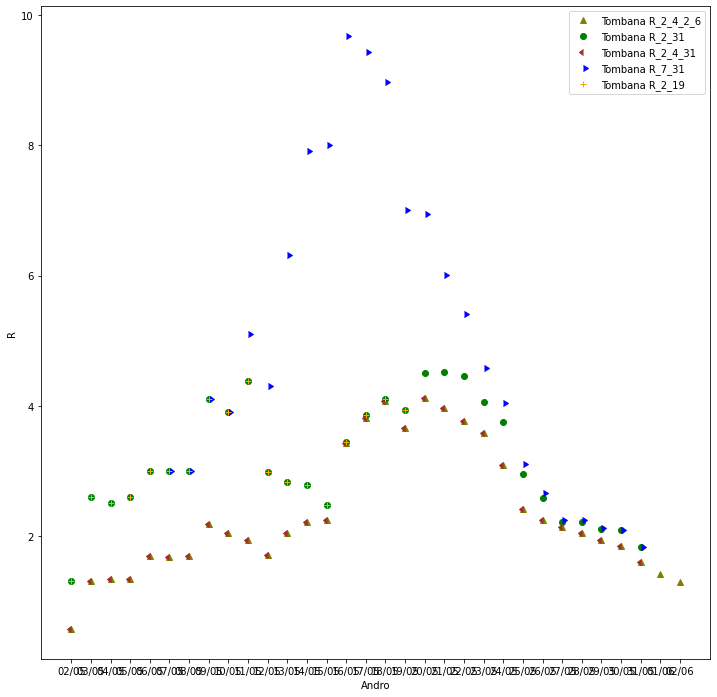

In [112]:
plt.figure(figsize=(12, 12))


# this is the order to follow for plotting
plt.plot(R_2_4_2_6_x, R_2_4_2_6_y, marker = "^", ls = 'None', color = 'olive', label='Tombana R_2_4_2_6')
plt.plot(R_2_31_x, R_2_31_y, marker = "o", ls = 'None', color = 'green', label='Tombana R_2_31')
plt.plot(R_2_4_31_x, R_2_4_31_y, marker = 8, ls = 'None', color = 'brown', label='Tombana R_2_4_31')
plt.plot(R_7_31_x, R_7_31_y, marker =9,ls = 'None', color='blue',label='Tombana R_7_31')
#plt.plot(R_10_31_x, R_10_31_y, marker =9,ls = 'None', color='blue',label='Tombana R_10_31')
#plt.plot(R_10_25_x, R_10_25_y, marker =8,ls = 'None', color='red',label='Tombana R_10_25')
plt.plot(R_2_19_x, R_2_19_y, marker = "+", ls = 'None', color='orange', label='Tombana R_2_19')

plt.xlabel('Andro')
plt.ylabel("R")
plt.legend(loc= 'best')

plt.savefig(path_to_save+'mampitahaR.eps')